
This tutorial proposes a way of analyzing an image of a drop on a SLIPS surface.
At the end of it, we will have gathered the important characteristics of the drop:

- its edge
- its base radius
- the position of the triple (oil-drop-vapor) point
- the apparent contact angles

## Installation of the needed packages

During this tutorial, we will need several python packages that need to be installed on your environment.
The majority of the needed packages can be installed from [PyPI](https://pypi.python.org/pypi) using the following command:

```sh
pip install imageio matplotlib numpy scipy
```

Or for conda users:

```sh
conda install imageio matplotlib numpy scipy
```

You will also need [OpenCV](https://opencv.org) to be installed.
For conda users on windows, you should be able to get this working with the following command:

```sh
conda install opencv

```

Or this one:
```sh
conda install -c menpo opencv
```

## Importing images
[Imageio](http://imageio.readthedocs.io/en/latest/index.html) package allows to import and export a variety of image format (see [here](http://imageio.readthedocs.io/en/latest/formats.html) for an exhaustive list).

Imageio can also import video or grab images directly from a camera.

In [1]:
import imageio
image = imageio.imread('data/image.bmp')

{{%expand "Explain me this block" %}}
We first imports the Imageio module.  
Then use its `imread()` function to read the image and store it in the `image` variable.
{{% /expand%}}

Images are stored as arrays of numbers.
We can display them using the [matplotlib](https://matplotlib.org/) package:

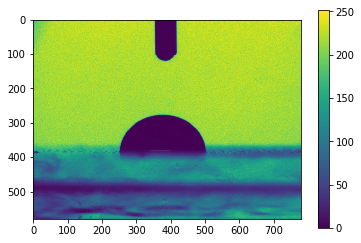

In [2]:
import matplotlib.pyplot as plt
plt.figure()
plt.imshow(image)
plt.colorbar()
plt.show()

{{%expand "Explain me this block" %}}
We first imports the `pyplot` module from matplotlib.
The `Pyplot` module is the main module for plotting data in a Matlab-way.   
We then create a figure with `plt.figure()`, display the image in it with `plt.imshow()`, add a colorbar with `plt.colorbar()` and show the results with `plt.show()`
{{% /expand%}}

## Cropping


The drop is centered on the image, but a part of the syringe that was used to drop it is also visible at the top.

As an edge detection performed on this image will certainly detect the syringe edges, it is a good idea to restrain the area of interest around the drop.

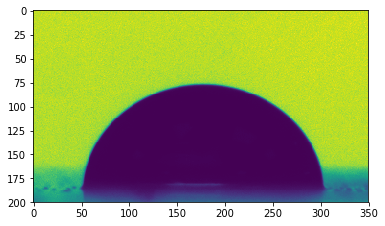

In [3]:
image = image[200:400, 200:550]

# Display
plt.figure()
plt.imshow(image)
plt.show()
              

{{%expand "Explain me this block" %}}
The `image` variable is an array and can be cropped using indices. 
It is here cropped from indice 200 to 550 on the x axis and from 200 to 400 on the y axis.
Because of the way image are referenced by the Imageio and matplotlib packages, the y axis has to be specified first.  
We then display the image.
{{% /expand%}}

## Edge detection
[OpenCV](https://opencv.org/) (Open Source Computer Vision Library) is a well-known library for image analysis that provides a python interface.
We will use one of its edge detection functions to get the edge of our drop.
More specifically, we will use the [Canny edge detector](https://en.wikipedia.org/wiki/Canny_edge_detector).

This method necessitates to specify two threshold values, that have to be optimized depending on the nature/quality of the edges to detect.
A first good guess is generally to take the minimal and maximal pixel values as thresholds.

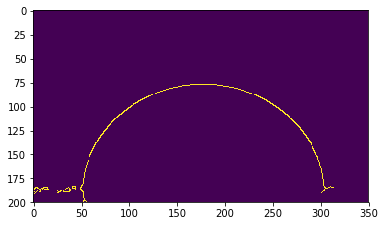

In [4]:
import cv2
thres1 = image.min()
thres2 = image.max()
edges = cv2.Canny(image, thres1, thres2)

# Display the obtained edges
plt.figure()
plt.imshow(edges)
plt.show()

{{%expand "Explain me this block" %}}
We import opencv with `import cv2`.  
Minimal and maximal pixel values are obtained using the `min()` and `max()` methods and stored.  
Those values are then used as arguments of the OpenCV edge detector: `Canny()`.  
The result is stored in the `edges` variable, and displayed.
{{% /expand%}}

The `Canny()` function returns an array of number that is equal to 1 (in yellow here) where edges have been detected.

OpenCV successfully detects the drop edges, but also some structures near the sample surface.
Lets improve the threshold values to get rid of those unwanted bits.

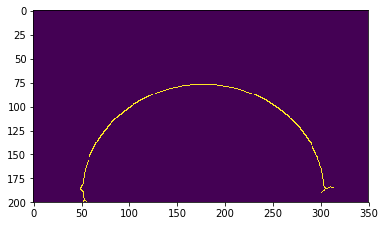

In [5]:
thres1 = image.min()*0.75
thres2 = image.max()*1.5
edges = cv2.Canny(image, thres1, thres2)

# Display the obtained edges
plt.figure()
plt.imshow(edges)
plt.show()

{{%expand "Explain me this block" %}}
The block is mainly similar to the previous one.  
The threshold values are just adjusted to get rid of the unwanted edges near the sample surface.
The thresholds values are now 0.75 times the minimal pixel value and 1.5 times the maximal pixel value.
{{% /expand%}}

We got rid of some of the unwanted bits, but we still detect some weird shapers due to the reflection of the drop on the sample.
We can remove them by deleting all the edges present below the baseline, that is here toughly around y=180.

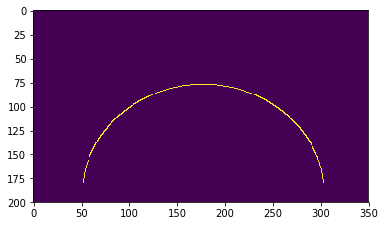

In [6]:
edges[180:, :] = 0

# Display the obtained edges
plt.figure()
plt.imshow(edges)
plt.show()

{{%expand "Explain me this block" %}}
`edges` is an array containing 1 where edges were detected.
To remove edges for y<180, we just need to fill the array with 0 for y<180 with `edges[180:, :] = 0`.
{{% /expand%}}

## From image to points
Drop edge is for the moment stored as an image, if we want to access its coordinates, we need to find the positions of each non-null pixels (yellow pixels).

The [numpy](http://www.numpy.org/) package can help us do that by detecting where the pixel values are not zero.

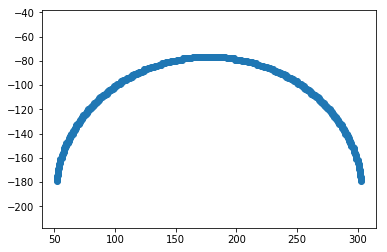

In [7]:
import numpy as np
ys, xs = np.where(edges)
ys = np.asarray(-ys, dtype=float)
xs = np.asarray(xs, dtype=float)

# Plot the edges
plt.figure()
plt.plot(xs, ys, marker='o', ls='none')
plt.axis('equal')
plt.show()

{{%expand "Explain me this block" %}}
We import numpy with `import numpy as np`.  
The `np.where()` function returns the positions of the array that are not equal to zero. 
Which are here the positions of the edges.  
The two following lines allow to transform the position from integers to floating point values.
This is needed for the next steps.  
`plt.plot()` allows to plot the edge points position.  
`plt.axis('equal')` ensures that the image is not deformed (stretched).
{{% /expand%}}

For convenience, we want to center the drop edge on the referential.

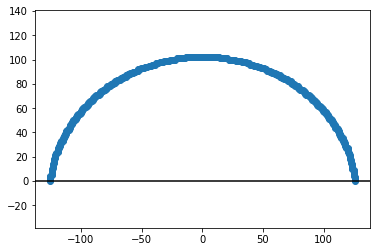

In [8]:
xs -= xs.mean()
ys -= ys.min()

# Plot the edges
plt.figure()
plt.plot(xs, ys, marker='o', ls='none')
plt.axhline(0, color='k')
plt.axis('equal')
plt.show()

{{%expand "Explain me this block" %}}
`xs.mean()` allows to access the average position of the edges along x.  
`ys.min()` allows to access the minimal position of the edges along y.  
{{% /expand%}}

## From pixels to mm

We now know the edge position in pixel.
To pass this information into millimeters, we just need to know the ratio between pixels and mm for our image.

It can be done by measuring the syringe diameter (here ~60 pixels) that we know is about 0.5mm.
This gives us a resolution of 120px/mm.

We then just need to scale our edge positions:

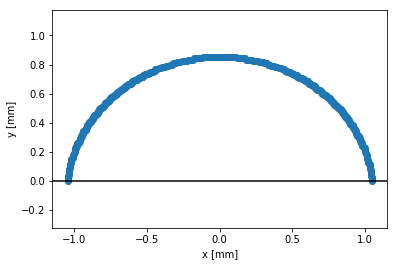

In [9]:
res = 120 
xs /= res
ys /= res

# Plot the edges
plt.figure()
plt.plot(xs, ys, marker='o', ls='none')
plt.axhline(0, color='k')
plt.axis('equal')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.show()

## Fitting the edge

Problem with the edge positions we obtained at this point is that they are at discrete positions (because extracted from an image).
It is impossible as it to obtain contact angles or triple point position.
In order to go further, we have to find a good fitting of the drop edge.

The [Scipy](https://www.scipy.org/) package provides several ways of fitting data.
Here, as we don't care about the mathematical expression of our fitting, we will use a spline fitting.

The Scipy fitting function needs the data to be sorted (strictly increasing x values).
We then need to fist ensure that our edges points are sorted.

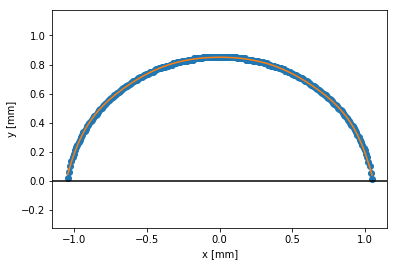

In [10]:
# Ensure increasing x values
new_xs = np.sort(list(set(xs)))
new_ys = []
for x in new_xs:
    new_ys.append(np.mean(ys[xs == x]))
xs = new_xs
ys = new_ys
# Find a fit
import scipy.interpolate as spint
edge_f = spint.UnivariateSpline(xs, ys, k=5, s=0.005)

# Display the fit
plt.figure()
plt.plot(xs, ys, marker='o', ls='none')
plt.plot(xs, edge_f(xs))
plt.axhline(0, color='k')
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
plt.show()

{{%expand "Explain me this block" %}}
We first sort the drop edges position along x and put them in the `new_xs` variable.  
Then, for each value of x, we average the associated values of y, to ensure that there is only one value of y for each x.  
We then perform the fitting using the `UnivariateSpline` function from Scipy.  
`k` and `s` parameters can be tuned to achieve smoother or more accurate fitting.  
We then display the edge and its fitting.
{{% /expand%}}

## Getting the drop basic properties

We can know extract some information from our data.
It is quite straightforward to get the drop base radius and height:

In [11]:
base_radius = np.max(xs) - np.min(xs)
height = np.max(ys)

# Print
print("Base radius: {} mm".format(base_radius))
print("Drop height: {} mm".format(height))

Base radius: 2.091666666666667 mm
Drop height: 0.85 mm


## Getting the contact angles

The contact angles are the angles done by our fitted curve where it meets the baseline (here `y=0`).


74.74264462928066
105.21597243751776


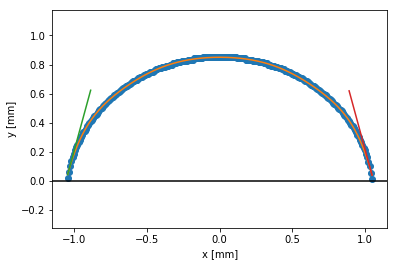

In [44]:
left_x = np.min(xs)
right_x = np.max(xs)
dx = (right_x - left_x)/100

# Left angle
import scipy.misc as spmisc
deriv = spmisc.derivative(edge_f, left_x, dx=dx)
theta_left =  np.arctan(deriv)

# Right angle
deriv = spmisc.derivative(edge_f, right_x, dx=dx)
theta_right = np.pi + np.arctan(deriv)

# Print
print(theta_left/np.pi*180)
print(theta_right/np.pi*180)

# Display the fit
plt.figure()
plt.plot(xs, ys, marker='o', ls='none')
plt.plot(xs, edge_f(xs))
plt.axhline(0, color='k')
angle_len = .6
plt.plot([left_x, left_x + angle_len*np.cos(theta_left)],
         [edge_f(left_x), edge_f(left_x) + angle_len*np.sin(theta_left)])
plt.plot([right_x, right_x + angle_len*np.cos(theta_right)],
         [edge_f(right_x), edge_f(right_x) + angle_len*np.sin(theta_right)])
plt.xlabel('x [mm]')
plt.ylabel('y [mm]')
plt.axis('equal')
plt.show()

{{%expand "Explain me this block" %}}
We first determine the position of the drop edge contact with the baseline along x.  
We then use the `derivative` function from Scipy to get the edges gradient at each contacts using the previous fitting.  
`dx` is used by the derivation algorithm. you can use a smaller value to get a more accurate result.  
The edge gradients are then translated to angles.  
The contact angle are then printed and displayed.
{{% /expand%}}

## Getting the triple point

Coming soon...